In [38]:
from numba import jit, njit
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import kwant.kpm


import scipy

import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

import cmath

from qutip import *
from joblib import Parallel, delayed


from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d  # For smoothing
from scipy.signal import argrelextrema
import pandas as pd


In [39]:

#Function to re-import the data and parameters from target file
# Read the parameters
params_sys = {}
with open('G_0clean.dat', 'r') as f:
    for line in f:
        if line.startswith("#"):
            key, value = line[1:].strip().split(" = ")
            params_sys[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
        else:
            break

t, Wc, Lc, alpha, xic, plate_distance, E_dis, E_img, ei, ef, Ne, iter_dis, Ncore = params_sys.values()

lB = 1./np.sqrt(2*np.pi*alpha)
omB = 4*np.pi*alpha

# Read the data
data = pd.read_csv('G_0clean.dat', sep=' ', comment='#')

energies_c= data['Energies'].to_numpy()
G0c = data['G0'].to_numpy()
GIMGc = data['GIMG'].to_numpy()

Gamma_img = 2*E_img/lB / ( (plate_distance/lB)**2 )


In [40]:

#Function to re-import the data and parameters from target file
# Read the parameters
params_sys = {}
with open('G_0dis.dat', 'r') as f:
    for line in f:
        if line.startswith("#"):
            key, value = line[1:].strip().split(" = ")
            params_sys[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
        else:
            break

t, Wd, Ld, alpha, xic, plate_distance, E_dis, E_img, ei, ef, Ne, iter_dis, Ncore = params_sys.values()

lB = 1./np.sqrt(2*np.pi*alpha)
omB = 4*np.pi*alpha

# Read the data
data = pd.read_csv('G_0dis.dat', sep=' ', comment='#')

energies_d= data['Energies'].to_numpy()
G0d = data['G0'].to_numpy()
GIMGd = data['GIMG'].to_numpy()

Gamma_img = E_img/lB / ( (plate_distance/lB)**2 )

Uwell = Gamma_img/omB

In [41]:
# Define a threshold: small fraction of max(fX)
threshold_shift_IMGT = .0001
threshold_shift_0T = .00001
Eshift_IMGc = 0
Eshift_0c = 0

# Find the first index where fX exceeds the threshold
nonzero_indices_IMGT = np.where(GIMGc > threshold_shift_IMGT)[0]
Eshift_IMGc = energies_c[nonzero_indices_IMGT[0]]

# Find the first index where fX exceeds the threshold
nonzero_indices_0T = np.where(G0c > threshold_shift_0T)[0]
Eshift_0c = energies_c[nonzero_indices_0T[0]]




# Define a threshold: small fraction of max(fX)
threshold_shift_IMGT = .0001
threshold_shift_0T = .00001
Eshift_IMGd = 0
Eshift_0d = 0

# Find the first index where fX exceeds the threshold
nonzero_indices_IMGT = np.where(GIMGd > threshold_shift_IMGT)[0]
Eshift_IMGd = energies_d[nonzero_indices_IMGT[0]]

# Find the first index where fX exceeds the threshold
nonzero_indices_0T = np.where(G0d > threshold_shift_0T)[0]
Eshift_0d = energies_d[nonzero_indices_0T[0]]


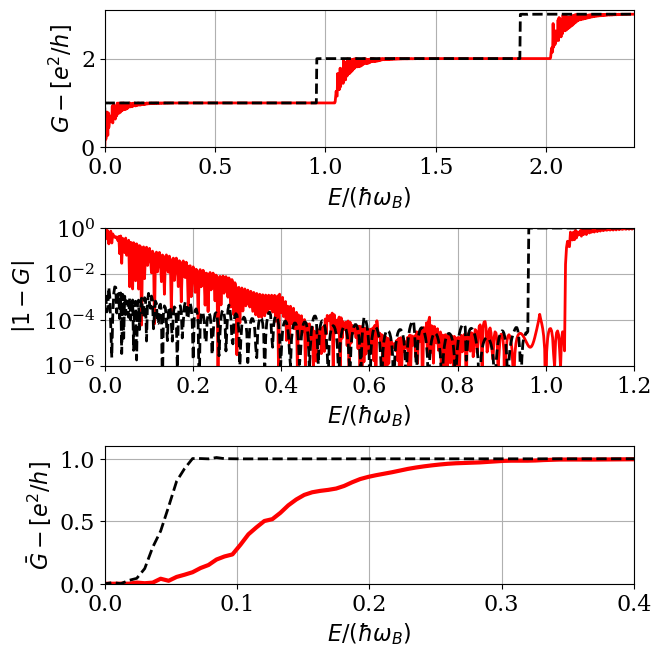

In [42]:
#print plateous
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
# First subplot
ax1.plot( (energies_c-Eshift_IMGc) / omB, GIMGc, color='red', linewidth=2)
ax1.plot( (energies_c-Eshift_0c) / omB, G0c, color='black', linewidth=2, linestyle='--')


ax1.set_ylabel(r"$G - [e^2/h]$", fontdict=font)
ax1.set_xlim( ( np.amin(energies_c/ omB), np.amax(energies_c/ omB)) )

ax2.plot( (energies_c-Eshift_IMGc) / omB, np.abs(1-GIMGc), color='red', linewidth=2, linestyle='-')
ax2.plot( (energies_c-Eshift_0c) / omB, np.abs(1-G0c), color='black', linewidth=2, linestyle='--')


ax2.set_ylabel(r"$|1-G|$", fontdict=font)
ax2.set_xlabel(r"$E/(\hbar\omega_B)$", fontdict=font)

xmin = 0
xmax = 2.4
ax1.set_ylim((.0, 3.1))
ax1.set_xlim((xmin, xmax))

ax2.set_ylim((1e-6, 1e0))  # Adjust the lower limit to avoid log(0) issues
ax2.set_xlim((0, 1.2))

ax2.set_yscale('log')  # Set log scale on y-axis

ax1.grid()
ax2.grid()
#ax1.set_xticklabels([])
ax1.set_xlabel(r"$E/(\hbar\omega_B)$", fontdict=font)

ax3.plot( (energies_d-Eshift_IMGd) / omB, GIMGd, color='red', linewidth=3)
ax3.plot( (energies_d-Eshift_0d) / omB, G0d, color='black', linewidth=2, linestyle='--')
ax3.grid()
ax3.set_ylim((.0, 1.1))
ax3.set_xlim((0, 0.4))


ax3.set_ylabel(r"$\bar{G} - [e^2/h]$", fontdict=font)
ax3.set_xlabel(r"$E/(\hbar\omega_B)$", fontdict=font)



plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 170 / 25.4)

plt.show()

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_60421/1177923490.py:54: RuntimeWarning: divide by zero encountered in divide
  T1 = 1/( 1 + Uwell**2/(4*x2*(x2+Uwell))/2 )
/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_60421/1177923490.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


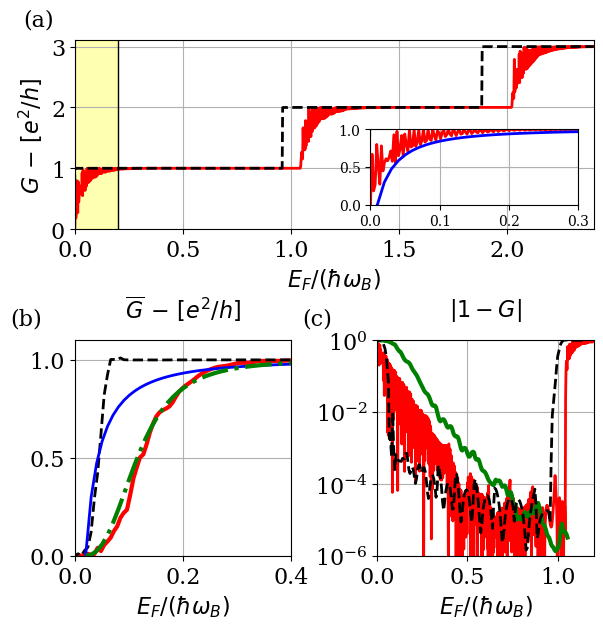

In [43]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create figure
fig = plt.figure(figsize=(8, 8))

# Define the grid layout
gs = gridspec.GridSpec(2, 2, height_ratios=[1.75, 2], hspace=0.55, wspace=0.4)

# Create subplots
ax1 = fig.add_subplot(gs[0, :])    # Top row, spans both columns
ax2 = fig.add_subplot(gs[1, 0])    # Bottom row, left column
ax3 = fig.add_subplot(gs[1, 1])    # Bottom row, right column


# --- ax1 ---
ax1.plot((energies_c - Eshift_IMGc) / omB, GIMGc, color='red', linewidth=2)
ax1.plot((energies_c - Eshift_0c) / omB, G0c, color='black', linewidth=2, linestyle='--')
ax1.set_ylabel(r"$G\, - \, [e^2/h]$", fontdict=font)
xmin, xmax = 0, 2.4
ax1.set_xlim((xmin, xmax))
ax1.set_ylim((0.0, 3.1))
ax1.grid()
ax1.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)

ax1.axvspan(0, Uwell, color='yellow', alpha=0.3)  # Shaded area in ax1
ax1.axvline(Uwell, color='black', linewidth=1)  # Right boundary



ax4 = ax1.inset_axes([0.57, 0.13, 0.4, 0.4])  
# [x0, y0, width, height] all relative to ax1 (fractions)

# Example plot inside ax4
ax4.plot((energies_c - Eshift_IMGc) / omB, GIMGc, color='red', linewidth=2)
ax4.plot((energies_c - Eshift_0c) / omB, G0c, color='black', linewidth=1, linestyle='--')

x2 = np.linspace(0,1,100)
T1 = 1/( 1 + Uwell**2/(4*x2*(x2+Uwell))/2 )
ax4.plot(x2 + .01, T1, color='blue', linewidth=2, linestyle='-')

ax4.set_xlim(0., .3)  # Example zoom
ax4.set_ylim(0., 1.)
ax4.grid()

# Optional: remove ticks or make them smaller
ax4.tick_params(axis='both', which='both', labelsize=10)

# Optional: add a box around the inset
ax4.set_facecolor('white')
ax4.patch.set_alpha(0.9)




# --- ax2 ---
ax3.plot((energies_c - Eshift_IMGc) / omB, np.abs(1 - GIMGc), color='red', linewidth=2, linestyle='-')
ax3.plot((energies_d - Eshift_IMGd) / omB, np.abs(1 - GIMGd), color='green', linewidth=3, linestyle='-')
ax3.set_xlim((0, 1.2))
ax3.set_ylim((1e-6, 1e0))
ax3.set_yscale('log')
ax3.grid()
ax3.plot((energies_d - Eshift_0d) / omB, np.abs(1 - G0d), color='black', linewidth=2, linestyle='--')
#ax3.set_ylabel(r"$|1-G|$", fontdict=font, labelpad=20, rotation=0)
#ax3.yaxis.set_label_position('left')
#ax2.yaxis.tick_left()

# Manually adjust position
#ax3.yaxis.label.set_verticalalignment('bottom')
#ax3.yaxis.label.set_horizontalalignment('left')
#ax3.yaxis.label.set_position((0.5, 1.05))  # (x, y) in axis coordinates


ax3.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)


# --- ax3 ---
ax2.plot((energies_d - Eshift_IMGd) / omB, GIMGd, color='red', linewidth=3)
ax2.plot((energies_d - Eshift_0d) / omB, G0d, color='black', linewidth=2, linestyle='--')


x2 = np.linspace(0.0001,1,100)
Uwell1 = Uwell
T1 = 1/( 1 + Uwell1**2/(4*x2*(x2+Uwell1))/2 ) 
ax2.plot(x2 + .02, T1, color='blue', linewidth=2, linestyle='-')

Uwell2 = Uwell#*2.5
fff = 8
T2 = 1/( 1 + fff*Uwell2**4/(4*x2*(x2+Uwell2))**2 ) #* np.exp( - .01/x2 )
#T2 = np.sqrt(T1)
ax2.plot(x2 + .02, T2, color='green', linewidth=3, linestyle='-.')
#ax2.plot((energies_c - Eshift_IMGc) / omB+.03, GIMGc, color='red', linewidth=2)



ax2.set_xlim((0, 0.4))
ax2.set_ylim((0.0, 1.1))
ax2.grid()
#ax2.set_ylabel(r"$\bar{G}\ [e^2/h]$", fontdict=font, labelpad=20, rotation=0)
#ax2.yaxis.set_label_position('left')
#ax2.yaxis.tick_left()

# Manually adjust position
#ax2.yaxis.label.set_verticalalignment('bottom')
#ax2.yaxis.label.set_horizontalalignment('left')
#ax2.yaxis.label.set_position((0, 1.05))  # (x, y) in axis coordinates

#ax2.set_ylabel(r"$\bar{G}\ [e^2/h]$", fontdict=font)
ax2.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)

# Remove normal ylabel
ax2.set_ylabel('')
ax3.set_ylabel('')

# Add manual text for ax2
ax2.text(
    0.5, 1.08, r"$\overline{G}\, - \, [e^2/h]$", 
    transform=ax2.transAxes, 
    ha='center', va='bottom', 
    fontsize=16
)

# Add manual text for ax3
ax3.text(
    0.5, 1.08, r"$|1-G|$", 
    transform=ax3.transAxes, 
    ha='center', va='bottom', 
    fontsize=16
)
    
    


# For ax1
ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, ha='left', va='bottom', fontsize=16)

# For ax2
ax2.text(-0.3, 1.05, '(b)', transform=ax2.transAxes, ha='left', va='bottom', fontsize=16)

# For ax3
ax3.text(-.35, 1.05, '(c)', transform=ax3.transAxes, ha='left', va='bottom', fontsize=16)



# Adjust layout
plt.tight_layout()

# Set figure size in mm
plt.gcf().set_size_inches(170 / 25.4, 170 / 25.4)

#plt.savefig('fig_L%d_W%d_dis%.2f_img%.2f_f%.2f_Uwell%.2f.pdf' % (Ld, Wd, E_dis/omB, E_img/omB, fff, Uwell))

plt.show()